In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
from tensorflow import Variable
import numpy as np
import matplotlib.pyplot as plt
import math

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


In this notebook, i illustrate physics informed nerual netowrks (PINNs) to solve the Balck Scholes Equation as proposed in

- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations*. [arXiv 1711.10561](https://arxiv.org/abs/1711.10561) 
- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations*. [arXiv 1711.10566](https://arxiv.org/abs/1711.10566) 
- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*. J. Comp. Phys. 378 pp. 686-707 [DOI: 10.1016/j.jcp.2018.10.045](https://www.sciencedirect.com/science/article/pii/S0021999118307125) 

This notebook is partially based on another implementation of the PINN approach published on [Google Colab by janblechschmidt](https://medium.com/@andeyharsha15/deep-neural-networks-for-solving-differential-equations-in-finance-da662ef0681), [Medium by Harsha Andey](https://medium.com/@andeyharsha15/deep-neural-networks-for-solving-differential-equations-in-finance-da662ef0681), [GitHub by pierremtb](https://github.com/pierremtb/PINNs-TF2.0) as well as the original code, see  [Maziar Raissi on GitHub](https://github.com/maziarraissi/PINNs).


## Introduction

We describe the PINN approach for approximating the solution $u:[0,T] \times \mathcal{D} \to \mathbb{R}$ of an evolution equation

$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$

where $\mathcal{N}$ is a nonlinear differential operator acting on $u$, 
$\mathcal{D} \subset \mathbb{R}^d$ a bounded domain,
$T$ denotes the final time and
$u_0: \mathcal{D} \to \mathbb{R}$ the prescribed initial data.
Although the methodology allows for different types of boundary conditions, we restrict our discussion to the inhomogeneous Dirichlet case and prescribe

$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$

where $\partial \mathcal{D}$ denotes the boundary of the domain $\mathcal{D}$ and $u_b: (0,T] \times \partial \mathcal{D} \to \mathbb{R}$ the given boundary data.

## Methodology

The method constructs a neural network approximation

$$
u_\theta(t,x) \approx u(t,x)
$$

of the solution of nonlinear PDE, where $u_\theta :[0,T] \times \mathcal{D} \to \mathbb{R}$ denotes a function realized by a neural network with parameters $\theta$.

The continuous time approach for the parabolic PDE as described in ([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)) is based on the (strong) residual of a given neural network approximation $u_\theta \colon [0,T] \times \mathcal{D} \to \mathbb{R} $ of the solution $u$, i.e.,

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

To incorporate this PDE residual $r_\theta$ into a loss function to be minimized, PINNs require a further differentiation to evaluate the differential operators $\partial_t u_\theta$ and $\mathcal{N}[u_\theta]$.
Thus the PINN term $r_\theta$ shares the same parameters as the original network $u_\theta(t,x)$, but respects the underlying "physics" of the nonlinear PDE.
Both types of derivatives can be easily determined through automatic differentiation with current state-of-the-art machine learning libraries, e.g., TensorFlow or PyTorch.

The PINN approach for the solution of the initial and boundary value problem now proceeds by minimization of the loss functional

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

where $X$ denotes the collection of training data and the loss function $\phi_\theta$ contains the following terms:

  - the mean squared residual
$$
  \begin{align*}
   \phi_\theta^r(X^r) := \frac{1}{N_r}\sum_{i=1}^{N_r} \left|r_\theta\left(t_i^r, x_i^r\right)\right|^2
\end{align*}
$$
in a number of collocation points $X^r:=\{(t_i^r, x_i^r)\}_{i=1}^{N_r} \subset (0,T] \times \mathcal{D}$, where $r_\theta$ is the physics-informed neural network,
  - the mean squared misfit with respect to the initial and boundary conditions
$$
    \begin{align*}
   \phi_\theta^0(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|u_\theta\left(t_i^0, x_i^0\right) - u_0\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \phi_\theta^b(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|u_\theta\left(t_i^b, x_i^b\right) - u_b\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}
$$
in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $u_\theta$ is the neural network approximation of the solution $u\colon[0,T] \times \mathcal{D} \to \mathbb{R}$.

Note that the training data $X$ consists entirely of time-space coordinates.

# Black Scholes Model
For a European call option:

$$
C(S, t) = SN(d1) - Ke^(-rt)N(d2)
$$

For a European put option:

$$
P(S, t) = Ke^(-rt)N(-d2) - SN(-d1)
$$

Where:

- C(S,t) is the value of the call option at time t
- P(S,t) is the value of the put option at time t
- S is the spot price of the underlying asset
- K is the strike price
- r is the risk-free interest rate
- t is the time to maturity
- N() is the cumulative distribution function of the standard normal distribution
- $d1 = [ln(S/K) + (r + 0.5σ²)(T-t)] / σ√(T-t)$
- $d2 = d1 - σ√(T-t)$
The variables within the square root sign σ and T represent the volatility of returns of the underlying asset and the time to maturity respectively.

The Black-Scholes model assumes that markets are efficient which means that there are no arbitrage opportunities, i.e., it is impossible to make a riskless profit. It also assumes that the volatility of the underlying asset is constant over time, and that the returns on the underlying asset are normally distributed.

# Black Scholes Partial Differential Equation
$$
{\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}+rS{\frac {\partial V}{\partial S}}-rV=0
$$

where we have greeks in the formula to measuer the sensitivity of the value of a portfolio to a small change in a given undrelying parameter. More explanation can be found in [Option Greeks from Investopedia by JohnSumma](https://www.investopedia.com/trading/getting-to-know-the-greeks/).

Five main greeks are:
- Delta: ${\frac {\partial V}{\partial S}}$ Measures impact of a change in the price of underlying
- Gamma: ${\frac {\partial ^{2}V}{\partial S^{2}}}$ Measures the rate of change of delta
- Theta: ${\frac {\partial V}{\partial t}}$ Measures impact of a change in time remaining
- Vega: ${\frac {\partial V}{\partial \sigma}}$ Measures impact of a change in volatility
- Rho: ${\frac {\partial V}{\partial r}}$ Measures the sensitivity of Derivative price w.r.t interest rate






In [2]:
# Define variables
S = tf.Variable([80.0], dtype=tf.float32)
t = tf.Variable([0.0], dtype=tf.float32)
sigma = tf.Variable([0.3], dtype=tf.float32)
r = tf.Variable([0.05], dtype=tf.float32)
K = tf.constant([70.0], dtype=tf.float32)
T = tf.constant([1.0], dtype=tf.float32)

For computing the Greeks, we use the `tf.GradientTape` for computing gradients as follows:

In [3]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch([t, S, sigma, r])
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([t, S, sigma, r])
        t2m = T - t
        d1 = (tf.math.log(S / K) + (r + 0.5 * sigma**2) * t2m) / (sigma * tf.sqrt(t2m))
        d2 = d1 - sigma * tf.sqrt(t2m)
        N0 = lambda value: 0.5 * (1 + tf.math.erf(value / tf.sqrt(2.0))) # type: ignore
        Nd1 = N0(d1)
        Nd2 = N0(d2)
        C = S * Nd1 - K * Nd2 * tf.exp(-r * t2m)
    theta = tape2.gradient(C, t, unconnected_gradients=tf.UnconnectedGradients.ZERO)[0]
    delta = tape2.gradient(C, S, unconnected_gradients=tf.UnconnectedGradients.ZERO)[0]
    vega = tape2.gradient(C, sigma, unconnected_gradients=tf.UnconnectedGradients.ZERO)[0]
    rho = tape2.gradient(C, r, unconnected_gradients=tf.UnconnectedGradients.ZERO)[0]
    

gamma = tape.gradient(delta, S, unconnected_gradients=tf.UnconnectedGradients.ZERO)[0]


for og in [theta, delta, gamma, vega, rho]:
    print(f'{og:.4f}')

result = (theta + 0.5 * sigma**2 * S**2 * gamma + r * S * delta - r * C).numpy()
print(f"Result: {result[0]:.4f}")

-5.8385
0.7769
0.0124
23.8776
45.1372
Result: 0.0000


Computing the option price

In [4]:
C = S * Nd1 - K * Nd2 * tf.exp(-r * t2m)

print("Option Price:", C[0]) #17.01496

Option Price: tf.Tensor(17.014957, shape=(), dtype=float32)


# Data Sampling
Here in our case, the system is European Call Option PDE and the physical information about the system consists of Boundary Value conditions, Initial Value conditions and the PDE itself.

The data samples are generated by the three functions:
- Sampler of data inputs for t and S for Differential Loss `get_diff_data()`
  - The price is initialized to be 0.
- Sampler of data inputs satisfying the boundary conditions for the PDE `get_bvp_data()`
  - The price of the lower bound and upper bound is computed correspondingly.
  - time is randomly sampled. 
- Sampler of data inputs satisfying the final value conditions for the PDE `get_fvp_data()`
  - time is set to be 1 (the expired time)
  - the option price is calculated by `gs: max(x-K, 0)`
- `n` is the number of samples



In [5]:
# constant initialisation
K = 40
r = 0.05
sigma = 0.25
T = 1
S_range = [0, 130]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)


def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1))
    return X, y

def get_bvp_data(n):
    # Price S = 0
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))
    
    # price S = Smax = 130
    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)
    
    return X1, y1, X2, y2

def get_fvp_data(n):
    X = np.concatenate([np.ones((n, 1)),
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)
    
    return X, y

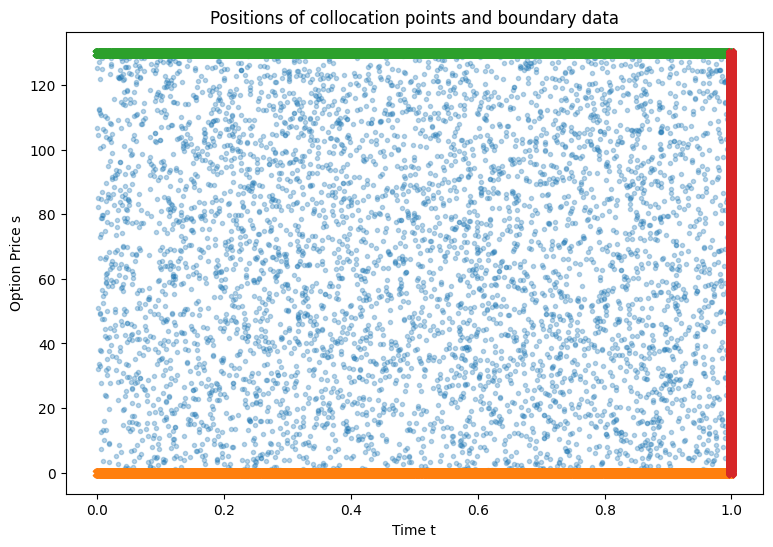

In [6]:
samples = {"pde": 5000, "bvp":5000, "fvp":5000}

a1, a2 = get_diff_data(samples['pde'])
b1, b2, c1, c2 = get_bvp_data(samples['bvp'])
d1, d2 = get_fvp_data(samples['fvp'])

fig = plt.figure(figsize=(9,6))
plt.scatter([sublist[0] for sublist in a1], [sublist[1] for sublist in a1], marker='.',alpha=0.3)
plt.scatter([sublist[0] for sublist in b1], [sublist[1] for sublist in b1], marker='X')
plt.scatter([sublist[0] for sublist in c1], [sublist[1] for sublist in c1], marker='X')
plt.scatter([sublist[0] for sublist in d1], [sublist[1] for sublist in d1], marker='X')
plt.xlabel('Time t')
plt.ylabel('Option Price s')

plt.title('Positions of collocation points and boundary data');

# Set up network architecture

#### Deep Galerkin Method Model Construction
The Neural Network based on the below model architecture given in Reference[1].


In [7]:

class DGMCell(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, n_layers=3, output_dim=1):
        super(DGMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n = n_layers

        self.sig_act = tf.keras.activations.tanh

        self.Sw = tf.keras.layers.Dense(self.hidden_dim)

        self.Uz = tf.keras.layers.Dense(self.hidden_dim)
        self.Wsz = tf.keras.layers.Dense(self.hidden_dim)

        self.Ug = tf.keras.layers.Dense(self.hidden_dim)
        self.Wsg = tf.keras.layers.Dense(self.hidden_dim)

        self.Ur = tf.keras.layers.Dense(self.hidden_dim)
        self.Wsr = tf.keras.layers.Dense(self.hidden_dim)
        
        self.Uh = tf.keras.layers.Dense(self.hidden_dim)
        self.Wsh = tf.keras.layers.Dense(self.hidden_dim)

        self.Wf = tf.keras.layers.Dense(output_dim)
    
    def call(self, x):
        S1 = self.Sw(x)
        for i in range(self.n):
            if i==0:
                S = S1
            else:
                S = self.sig_act(out)
            Z = self.sig_act(self.Uz(x) + self.Wsz(S))
            G = self.sig_act(self.Ug(x) + self.Wsg(S1))
            R = self.sig_act(self.Ur(x) + self.Wsr(S))
            H = self.sig_act(self.Uh(x) + self.Wsh(S*R))
            out = (1-G)*H + Z*S
        out = self.Wf(out)
        return out

model = DGMCell(2, 100, 3, 1)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

n_epochs = 60000
samples = {"pde": 5000, "bvp":5000, "ivp":5000}
criterion = tf.keras.losses.MeanSquaredError()

#### A feedforward neural network of the following architecture
- one input layer with 2 neurons
- 8 fully connected layers each containing 20 neurons and each followed by a hyperboloc tangent actiavtion function,
- one fully connected ouput layer

This setting results in a network with 3021 trainable parameters (first hidden layer: 2⋅20+20=60; seven intermediate layers: each 20⋅20+20=420; output layer: 20⋅1+1=21).

In [8]:
# Define hyperparameters
input_size = 2  # Number of input features
hidden_size = 50  # Number of neurons in the hidden layer
output_size = 1   # Number of output features
n_layers = 3
learning_rate = 3e-5


# Input layer
inputs = tf.keras.Input(shape=(input_size,))

# Add hidden layers using a for loop
x = inputs
for i in range(n_layers):
    x = tf.keras.layers.Dense(hidden_size, activation='relu')(x)
    
# Output layer
outputs = tf.keras.layers.Dense(output_size)(x)


# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)


# Define loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn)

# Print the model summary
model.summary()


n_epochs = 60000
samples = {"pde": 5000, "bvp":5000, "fvp":5000}
criterion = tf.keras.losses.MeanSquaredError()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 50)                150       
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


# Modelling

In [9]:
loss_hist = []

for epoch in range(n_epochs):
    with tf.GradientTape(persistent=True) as tape:
        
        # PDE Round
        X1, y1 = get_diff_data(samples['pde'])
        X1 = tf.convert_to_tensor(X1, dtype=tf.float32)
        y1 = tf.convert_to_tensor(y1, dtype=tf.float32)

        with tf.GradientTape(persistent=True) as t2:
            t2.watch(X1)
            with tf.GradientTape(persistent=True) as t1:
                t1.watch(X1)
                y1_hat = model(X1, training=True)
            grads = t1.gradient(y1_hat, X1, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        dVdt, dVdS = tf.reshape(grads[:, 0], [-1, 1]), tf.reshape(grads[:, 1], [-1, 1])
        grads2nd = t2.gradient(dVdS, X1, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        
        d2VdS2 = tf.reshape(grads2nd[:, 1], [-1, 1])
        S1 = tf.reshape(X1[:, 1], [-1, 1])
        pde_loss = criterion(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)

        # BVP Round
        X21, y21, X22, y22 = get_bvp_data(samples['bvp'])

        X21 = tf.convert_to_tensor(X21, dtype=tf.float32)
        y21 = tf.convert_to_tensor(y21, dtype=tf.float32)

        X22 = tf.convert_to_tensor(X22, dtype=tf.float32)
        y22 = tf.convert_to_tensor(y22, dtype=tf.float32)

        y21_hat = model(X21, training=True)
        bvp1_loss = criterion(y21, y21_hat)

        y22_hat = model(X22, training=True)
        bvp2_loss = criterion(y22, y22_hat)

        # FVP Round
        X3, y3 = get_fvp_data(samples['fvp'])

        X3 = tf.convert_to_tensor(X3, dtype=tf.float32)
        y3 = tf.convert_to_tensor(y3, dtype=tf.float32)

        y3_hat = model(X3, training=True)
        ivp_loss = criterion(y3, y3_hat)

        # Combined loss
        combined_loss = pde_loss + bvp1_loss + bvp2_loss + ivp_loss

    # Backpropagation and update
    gradients = tape.gradient(combined_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    loss_hist.append(combined_loss.numpy())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.numpy():.5f}, BVP1 Loss: {bvp1_loss.numpy():.5f}, BVP2 Loss: {bvp2_loss.numpy():.5f}, FVP Loss: {ivp_loss.numpy():.5f},')

0/60000 PDE Loss: 0.00100, BVP1 Loss: 0.00746, BVP2 Loss: 4453.55029, FVP Loss: 903.11700,
500/60000 PDE Loss: 0.01023, BVP1 Loss: 0.00020, BVP2 Loss: 464.39160, FVP Loss: 149.49796,
1000/60000 PDE Loss: 0.31570, BVP1 Loss: 0.00156, BVP2 Loss: 27.92808, FVP Loss: 195.96471,
1500/60000 PDE Loss: 1.25708, BVP1 Loss: 0.00100, BVP2 Loss: 20.51344, FVP Loss: 192.97330,
2000/60000 PDE Loss: 3.18117, BVP1 Loss: 0.00110, BVP2 Loss: 17.70261, FVP Loss: 170.58632,
2500/60000 PDE Loss: 6.51858, BVP1 Loss: 0.00040, BVP2 Loss: 15.38184, FVP Loss: 157.75722,
3000/60000 PDE Loss: 11.67604, BVP1 Loss: 0.00017, BVP2 Loss: 12.72788, FVP Loss: 138.59868,
3500/60000 PDE Loss: 18.50987, BVP1 Loss: 0.00004, BVP2 Loss: 11.23074, FVP Loss: 117.49072,
4000/60000 PDE Loss: 26.01580, BVP1 Loss: 0.00001, BVP2 Loss: 9.75165, FVP Loss: 98.31748,
4500/60000 PDE Loss: 31.91838, BVP1 Loss: 0.00001, BVP2 Loss: 8.21769, FVP Loss: 85.94471,
5000/60000 PDE Loss: 34.82006, BVP1 Loss: 0.00002, BVP2 Loss: 7.33027, FVP Loss: 

KeyboardInterrupt: 